# Basic EDA
### Get score level analytics on Numerical Variables available

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
# Sometimes we want to see more than a single output in the cell below command enables that
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity="all"

In [2]:
from lightgbm import LGBMRegressor

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/cat-dict/cat_dict
/kaggle/input/linking-writing-processes-to-writing-quality/sample_submission.csv
/kaggle/input/linking-writing-processes-to-writing-quality/test_logs.csv
/kaggle/input/linking-writing-processes-to-writing-quality/train_scores.csv
/kaggle/input/linking-writing-processes-to-writing-quality/train_logs.csv


In [5]:
train = pd.read_csv("/kaggle/input/linking-writing-processes-to-writing-quality/train_logs.csv")
test = pd.read_csv("/kaggle/input/linking-writing-processes-to-writing-quality/test_logs.csv")
train_scores = pd.read_csv("/kaggle/input/linking-writing-processes-to-writing-quality/train_scores.csv")
sample_submission = pd.read_csv("/kaggle/input/linking-writing-processes-to-writing-quality/sample_submission.csv")

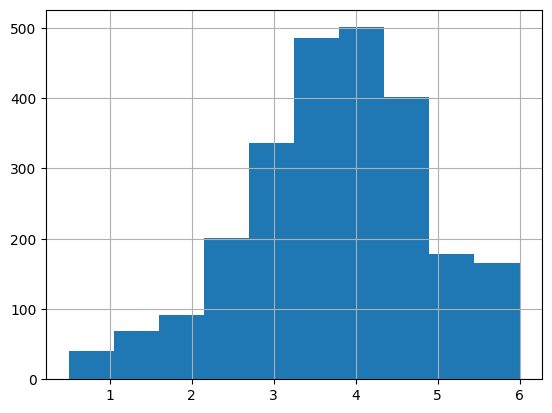

In [6]:
train_scores.score.hist()
plt.show();

In [7]:
train['id'] = train['id'].astype(str)
train_scores['id'] = train_scores['id'].astype(str)

In [8]:
# Add the score
train=train.merge(train_scores,left_on ="id",right_on="id",how="left")

# Averages on Action time

In [9]:
# See average word count and action time corresponding to scores
train.groupby("score").agg({"action_time":"mean",
                                 "word_count":(max,min,"mean"),
                                  "event_id":"mean"
                           })

action_time word_count                     event_id
             mean        max min        mean         mean
score                                                    
0.5    108.179308        313   0  114.293968   802.570756
1.0    105.574167        451   0  136.023399  1206.570358
1.5     95.382315        568   0  143.304741  1259.687360
2.0     98.456583        855   0  131.562149  1161.031217
2.5     99.696969        847   0  150.510128  1380.885537
3.0    101.614095        887   0  160.319410  1519.664800
3.5     99.468483       1071   0  194.954310  1741.764347
4.0     99.711023       1247   0  223.114869  2032.933342
4.5     95.665620       1141   0  258.940124  2308.972109
5.0     94.237049       1186   0  292.785950  2600.685248
5.5     96.717079       1326   0  341.192093  2940.417711
6.0     95.085620       1233   0  370.985322  3027.016845

* Average word count is higher in higher scores but the above metric is actually the average of "word count after every event"
* Average number of events also increase with score...
* Action time average above is the mean of the action time after every event 
* So low action time accompanied by higher word count/ number of events corresponds to a good score
* But these are not exact metrics at ID level, we will need to create a dataframe at ID level taking mean, min, max of event_id , action_time , word_count

In [10]:
# to build the legend as it is not appearing with the normal command
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
import matplotlib.ticker

# Average Word Count& Events

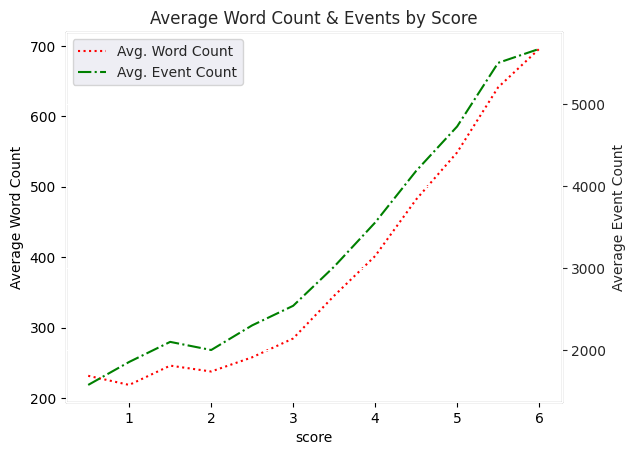

In [11]:
# let's get avg of word count in the essays corresponding to each score
# and the max events that an essay has
# We are taking max for event and word count because we want to see the total events that occured while writing the essay 
# and average word count of writers in each score level
essay=train.groupby("id").agg({"action_time":"mean",
                                 "word_count":max,
                                  "event_id":max,
                                   "score":max})

# Display the score wise word counts from each ID 
# this enables us to view what was the word count level at a use 
lineplot =essay.groupby("score").agg({"action_time":"mean",
                                 "word_count":("mean"),
                                  "event_id":("mean")
                           })

lineplot

fig,ax= plt.subplots()
sns.set_style('darkgrid')
plt.rcParams["figure.figsize"]=(8,5)
#sns.lineplot(data=lineplot,x="score",y="action_time",ax=ax)
sns.lineplot(data=lineplot,x="score",y="word_count",ax=ax,color="red",linestyle="dotted")
plt.ylabel("Average Word Count")
ax2=ax.twinx()
sns.lineplot(data=lineplot,x="score",y="event_id",ax=ax2,color="green",linestyle="-.")
plt.ylabel("Average Event Count")
plt.title("Average Word Count & Events by Score")
red_patch=Line2D([0],[0],color="red",label="Avg. Word Count",linestyle="dotted")
green_patch=Line2D([0],[0],color="green",label="Avg. Event Count",linestyle="-.")
plt.legend(handles=[red_patch,green_patch],loc="upper left")
plt.show();

In [12]:
lineplot

,action_time,word_count,event_id
score,,,
0.5,105.367020,231.400000,1571.600000
1.0,101.907062,218.457143,1852.371429
1.5,97.733989,245.855072,2097.289855
2.0,100.038292,237.510870,1997.923913
2.5,100.669885,257.701493,2298.995025
3.0,101.860359,284.449405,2537.883929
3.5,101.193658,345.119342,3015.973251
4.0,101.707980,401.532934,3554.778443
4.5,96.978518,481.843284,4184.850746


# Takeaway
 So we can confirm that people who write longer worded essays score higher
 They have more events as a reason
 but the action time between their events is low

In [13]:
# Add most common actions in eachs core band, % of events that happen for a 
train.head()

,id,event_id,down_time,up_time,action_time,activity,down_event,up_event,text_change,cursor_position,word_count,score
0,001519c8,1,4526,4557,31,Nonproduction,Leftclick,Leftclick,NoChange,0,0,3.5
1,001519c8,2,4558,4962,404,Nonproduction,Leftclick,Leftclick,NoChange,0,0,3.5
2,001519c8,3,106571,106571,0,Nonproduction,Shift,Shift,NoChange,0,0,3.5
3,001519c8,4,106686,106777,91,Input,q,q,q,1,1,3.5
4,001519c8,5,107196,107323,127,Input,q,q,q,2,1,3.5


In [14]:
# What events correspond to high scores
# lets compute
# Avg Score per down event and up event
# In each score bin what are 10 most occuring upevents and down events
# In each score band what is the ditribtuin of activities Non production , input , replace etc

# Avg Score vs Down Event

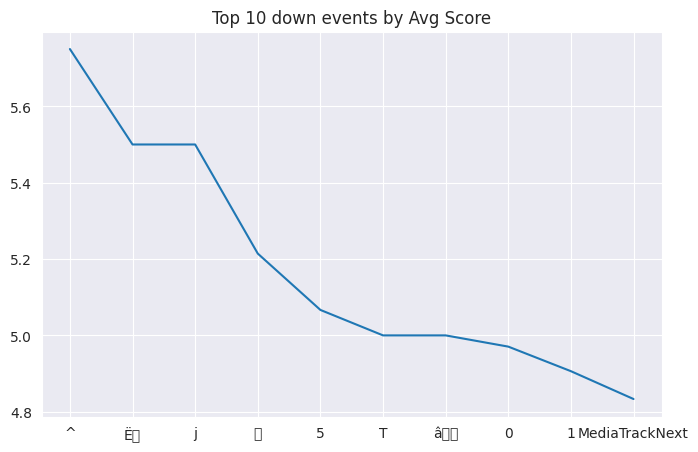

In [15]:
plt.plot(train.groupby("down_event").agg({'score':"mean"}).sort_values("score",ascending= False).head(10))
plt.title("Top 10 down events by Avg Score")
plt.show();

# Avg Score by Upevent

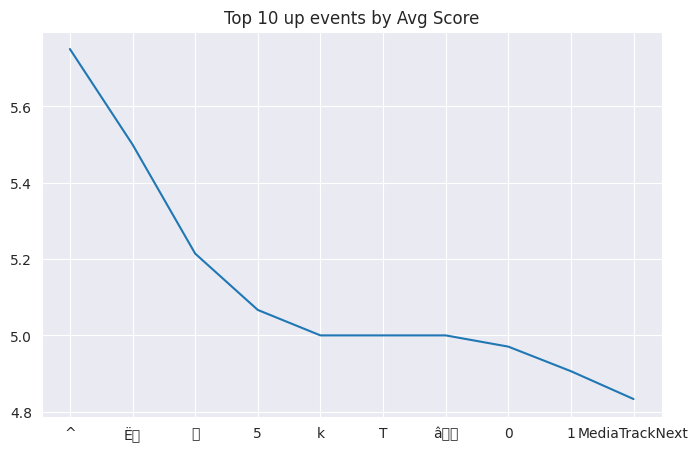

In [16]:
plt.plot(train.groupby("up_event").agg({'score':"mean"}).sort_values("score",ascending= False).head(10))
plt.title("Top 10 up events by Avg Score")
plt.show();

# Avg Text by Score

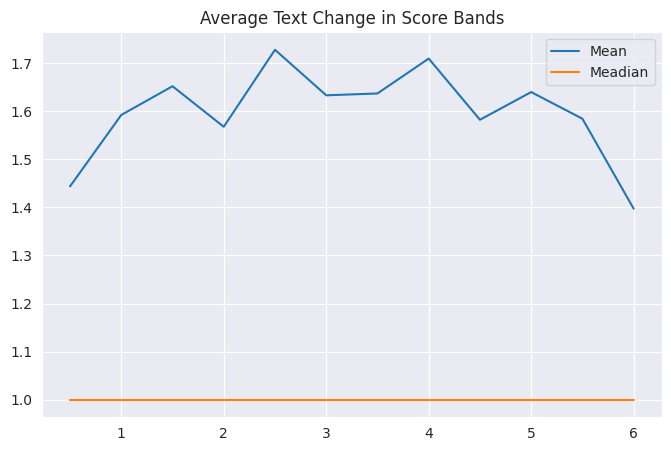

In [17]:
#  Text change how much did the person actually write or change his previous version of the essay
train.loc[:,'text_change_length'] = train['text_change'].apply(lambda x:len(x))
plt.plot(train.groupby("score").agg({'text_change_length':"mean"}),label="Mean")
plt.plot(train.groupby("score").agg({'text_change_length':"median"}),label="Meadian")
plt.legend()
plt.title("Average Text Change in Score Bands")
plt.show();

hmmm. so avg low lenght of text changes can be indicative of low or high score. Fishy. Variable is proabably segmented with effect of another variable or this means that the lenght of text changes are consistent and then there are large deviations which shit the mean but they do not happen in either of high scores or low scores..... so some events could consistently point to a low score and some likely to hhigh score.

# Lightgbm

In [18]:
# Lets build a baseline light gbm and then use shap to generate feature importance chart

In [19]:
from random import sample
# We want to make sure there is peeking into the test set
# In the first pass let's just simplify these variables
train.loc[:,'text_change_length'] = train['text_change'].apply(lambda x:len(x))
train.loc[:,'activity_c']=train['activity'].apply(lambda x:"move" if "Move" in x else x )

test_id=sample(list(train.id.unique()),300)
# Get train and test based on test id
train_m= train[~train.id.isin(test_id)]
test_m= train[train.id.isin(test_id)]

In [20]:
# let's create a dictionary to store the factorisers for categorical variables
cats=['activity_c','down_event','up_event']
# This is basically code to create dictionary
# cat_dict={}
# for i in cats:
#     cat_dict[i]={}
#     for j in range(0,len(list(train_m[i].unique()))):
#         cat_dict[i][list(train_m[i].unique())[j]]=j

In [21]:
import joblib
# lets load the saved data dictionary
cat_dict=joblib.load("/kaggle/input/cat-dict/cat_dict")

In [22]:
model_vars=['event_id', 'down_time', 'up_time', 'action_time',
       'down_event', 'up_event', 'cursor_position',
       'word_count','text_change_length', 'activity_c']

X_train=train_m.copy()
X_test=test_m.copy()
# Convert categorical to mapping
for i in cats:
    X_train[i]=X_train[i].map(cat_dict[i])
    X_test[i]=X_test[i].map(cat_dict[i])
    #X_train.loc[:,i]=X_train[i].astype("int")
    #X_test.loc[:,i]=X_test[i].astype("int")

In [23]:
lgb=LGBMRegressor()
lgb.fit(X_train[model_vars], X_train['score'],
        eval_set=[(X_test[model_vars], X_test['score'])],
        categorical_feature=cats,
        verbose=0,
        early_stopping_rounds=8)

LGBMRegressor()

# Feature Importance

In [24]:
import shap

In [25]:
# Explain model predictions using shap library:
explainer = shap.TreeExplainer(lgb)
shap_values = explainer.shap_values(X_test[model_vars])

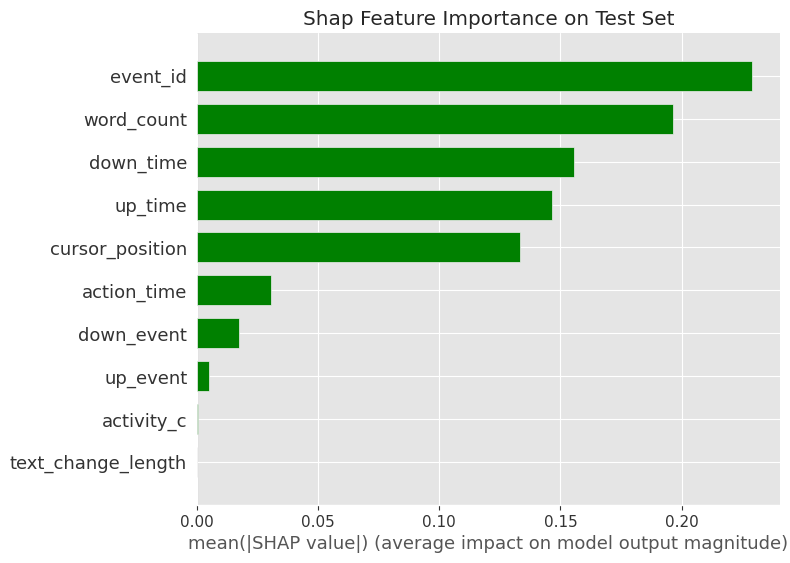

In [26]:
# Plot summary_plot as barplot:
plt.style.use('ggplot')
shap.summary_plot(shap_values, X_test[model_vars], plot_type='bar',color ='green',show=False)
plt.title("Shap Feature Importance on Test Set")
plt.show();

#### So basically activity and text change are useless the way used above. We need to extract the cordinate change from activity and identify some way of modelling text change as it has too high cardinality to model even for light gbm